In [84]:
import os
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import torch
import galsim
import ngmix
from utils.utils import estimate_shear

%matplotlib inline

In [85]:
def make_data(rng, noise, g1=0.05, g2=-0.02, flux=100.0, fracdev=0.5):
    """
    simulate an exponential object with moffat psf

    Parameters
    ----------
    rng: np.random.RandomState
        The random number generator
    noise: float
        Noise for the image
    g1: float
        object g1, default 0.05
    g2: float
        object g2, default -0.02
    flux: float, optional
        default 100

    Returns
    -------
    ngmix.Observation, pars dict
    """

    # psf_noise = 1.0e-6

    # scale = 0.263

    # psf_fwhm = 0.9
    # gal_hlr = 0.5
    # dy, dx = rng.uniform(low=-scale/2, high=scale/2, size=2)

    # psf = galsim.Moffat(
    #     beta=2.5, fwhm=psf_fwhm,
    # ).shear(
    #     g1=-0.01,
    #     g2=-0.01,
    # )

    # disk = galsim.Exponential(
    #     half_light_radius=gal_hlr,
    #     flux=flux*(1-fracdev),
    # ).shear(
    #     g1=g1,
    #     g2=g2,
    # )
    # bulge = galsim.DeVaucouleurs(
    #     half_light_radius=gal_hlr,
    #     flux=flux*fracdev,
    # ).shear(
    #     g1=g1,
    #     g2=g2,
    # )

    # obj0 = galsim.Add([disk, bulge])
    # obj0 = obj0.shift(
    #     dx=dx,
    #     dy=dy,
    # )

    # obj = galsim.Convolve(psf, obj0)

    # psf_im = psf.drawImage(scale=scale).array
    # im = obj.drawImage(scale=scale).array

    # psf_im += rng.normal(scale=psf_noise, size=psf_im.shape)
    # im += rng.normal(scale=noise, size=im.shape)
    psf_im = torch.load("psf_23.5_0.pth").numpy()
    im = torch.load("obs_23.5_0.pth").numpy()
    

    # cen = (np.array(im.shape)-1.0)/2.0
    # psf_cen = (np.array(psf_im.shape)-1.0)/2.0

    # jacobian = ngmix.DiagonalJacobian(
    #     row=cen[0] + dy/scale, col=cen[1] + dx/scale, scale=scale,
    # )
    # psf_jacobian = ngmix.DiagonalJacobian(
    #     row=psf_cen[0], col=psf_cen[1], scale=scale,
    # )

    # wt = im*0 + 1.0/noise**2
    # psf_wt = psf_im*0 + 1.0/psf_noise**2

    psf_obs = ngmix.Observation(
        psf_im,
        # weight=psf_wt,
        # jacobian=psf_jacobian,
    )

    obs = ngmix.Observation(
        im,
        # weight=wt,
        # jacobian=jacobian,
        psf=psf_obs,
    )

    obj_pars = {
        'g1': g1,
        'g2': g2,
        'flux': flux,
        'fracdev': fracdev,
    }
    return obs, obj_pars

def get_prior(*, rng, scale, T_range=None, F_range=None, nband=None):
    """
    get a prior for use with the maximum likelihood fitter

    Parameters
    ----------
    rng: np.random.RandomState
        The random number generator
    scale: float
        Pixel scale
    T_range: (float, float), optional
        The range for the prior on T
    F_range: (float, float), optional
        Fhe range for the prior on flux
    nband: int, optional
        number of bands
    """
    if T_range is None:
        T_range = [-1.0, 1.e3]
    if F_range is None:
        F_range = [-100.0, 1.e9]

    g_prior = ngmix.priors.GPriorBA(sigma=0.1, rng=rng)
    cen_prior = ngmix.priors.CenPrior(
        cen1=0, cen2=0, sigma1=scale, sigma2=scale, rng=rng,
    )
    T_prior = ngmix.priors.FlatPrior(minval=T_range[0], maxval=T_range[1], rng=rng)
    fracdev_prior = ngmix.priors.Normal(mean=0.5, sigma=0.1, rng=rng)
    F_prior = ngmix.priors.FlatPrior(minval=F_range[0], maxval=F_range[1], rng=rng)

    if nband is not None:
        F_prior = [F_prior]*nband

    prior = ngmix.joint_prior.PriorBDFSep(
        cen_prior=cen_prior,
        g_prior=g_prior,
        T_prior=T_prior,
        fracdev_prior=fracdev_prior,
        F_prior=F_prior,
    )

    return prior


S/N: 5688.313955492549
true flux: 100 meas flux: 118742 +/- 12009.4 (99.7% conf)
true g1: 0.05 meas g1: 0.131336 +/- 0.0331082 (99.7% conf)
true g2: -0.02 meas g2: -0.0629362 +/- 0.0328385 (99.7% conf)
true fracdev: 0.5 meas fracdev: 1.01417 +/- 0.0899249 (99.7% conf)


Text(0.5, 1.0, '(0.270,-0.150)')

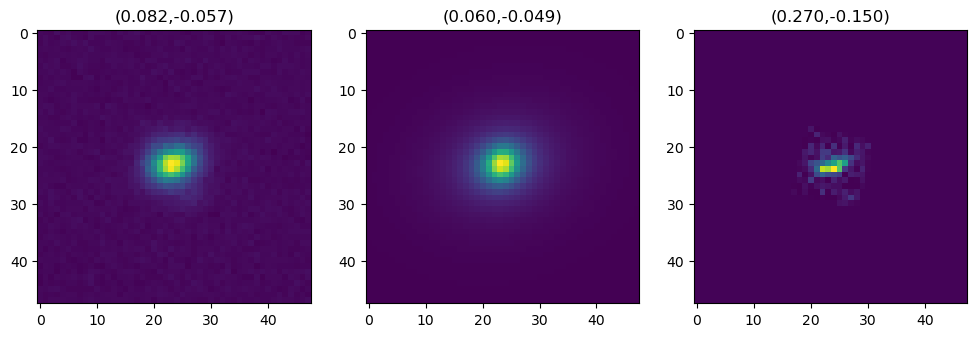

In [86]:
rng = np.random.RandomState(235)

obs, obj_pars = make_data(rng=rng, noise=0.01)

# fit the object to an exponential disk
prior = get_prior(rng=rng, scale=obs.jacobian.scale)
# fit bulge+disk with fixed size ratio, using the levenberg marquards
# algorithm
fitter = ngmix.fitting.Fitter(model='bdf', prior=prior)
# make parameter guesses based on a psf flux and a rough T
guesser = ngmix.guessers.TPSFFluxAndPriorGuesser(
    rng=rng,
    T=0.25,
    prior=prior,
)

# psf fitting with coelliptical gaussians
psf_ngauss = 5
psf_fitter = ngmix.em.EMFitter()
# guesses full gmix objects
psf_guesser = ngmix.guessers.GMixPSFGuesser(rng=rng, ngauss=psf_ngauss)

# this runs the fitter. We set ntry=2 to retry the fit if it fails
psf_runner = ngmix.runners.PSFRunner(
    fitter=psf_fitter, guesser=psf_guesser,
    ntry=2,
)
runner = ngmix.runners.Runner(
    fitter=fitter, guesser=guesser,
    ntry=2,
)

# this bootstraps the process, first fitting psfs then the object
boot = ngmix.bootstrap.Bootstrapper(
    runner=runner,
    psf_runner=psf_runner,
)

res = boot.go(obs)

print()
print('S/N:', res['s2n'])
print('true flux: %g meas flux: %g +/- %g (99.7%% conf)' % (
    obj_pars['flux'], res['flux'], res['flux_err']*3,
))
print('true g1: %g meas g1: %g +/- %g (99.7%% conf)' % (
    obj_pars['g1'], res['g'][0], res['g_err'][0]*3,
))
print('true g2: %g meas g2: %g +/- %g (99.7%% conf)' % (
    obj_pars['g2'], res['g'][1], res['g_err'][1]*3,
))
fracdev = res['pars'][5]
fracdev_err = np.sqrt(res['pars_cov'][5, 5])
print('true fracdev: %g meas fracdev: %g +/- %g (99.7%% conf)' % (
    obj_pars['fracdev'], fracdev, fracdev_err,
))

psf_delta = np.zeros([48, 48])
psf_delta[23,23] = 1
    
gt = torch.load("gt_23.5_0.pth").numpy()
gt_shear = estimate_shear(gt, psf_delta)
obs = torch.load("obs_23.5_0.pth").numpy()
obs_shear = estimate_shear(obs, psf_delta)
rec = res.make_image()
rec_shear = estimate_shear(rec, psf_delta)


plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(obs)
plt.title('({:.3f},{:.3f})'.format(obs_shear[0],obs_shear[1]))
plt.subplot(1,3,2)
plt.imshow(rec)
plt.title('({:.3f},{:.3f})'.format(rec_shear[0],rec_shear[1]))
plt.subplot(1,3,3)
plt.imshow(gt)
plt.title('({:.3f},{:.3f})'.format(gt_shear[0],gt_shear[1]))